# Stock Market Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
nex_companies = pd.read_csv('./Data/NEX_companies.csv', index_col=0)
nex_companies.sample(5)

,company name,description,sec.,cur.,country,symbol
10,First Solar,"Thin film solar, CdTe low-cost alternate to po...",RSR,USD,US,FSLR
17,Nio,"EVs, design, manufacture, and sale including SUVs",ENS,USD,CHINA,NIO
3,Bloom Energy,"Stationary fuel cells, distributed but non-ren...",ECV,USD,US,BE
12,Hannon Armstrong,"Energy efficiency, capital & finance for infra...",EEF,USD,US,HASI
4,BYD Co.,"Batteries, potential use in EVs, rail, solar f...",ENS,HKD,CHINA,BYDDF


## Companies distribution

### Country

In [3]:
nex_companies.groupby('country')['country'].count().sort_values(ascending=False)

country
US         22
CHINA       8
GERMANY     5
INDIA       1
Name: country, dtype: int64

### Sector

The companies listed in the NEX are divided into 7 sectors:

* ECV: Energy Conversion
* EEF: Energy Efficiency
* ENS: Energy Storage
* RBB: Renewables - Biofuels & Biomass
* ROH: Renewables - Other
* RSR: Renewable - Solar
* RWD: Renewable - Wind

In [4]:
nex_companies.groupby('sec.')['sec.'].count().sort_values(ascending=False)

sec.
RSR    13
EEF     7
RWD     5
ENS     4
RBB     3
ECV     3
ROH     1
Name: sec., dtype: int64

## The full NEX index

Text(0, 0.5, 'Close')

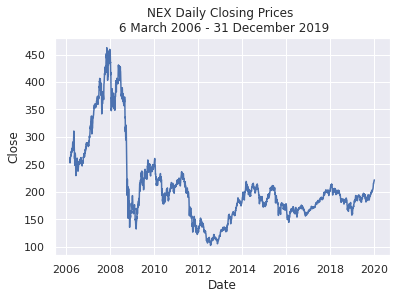

In [5]:
nex_full = pd.read_excel('./Data/NEX_full_prices.xlsx')

l = sns.lineplot(data=nex_full, x='Date', y='Close')
l.set_title('NEX Daily Closing Prices \n 6 March 2006 - 31 December 2019')
l.set_ylabel('Close', rotation=90)

Text(0, 0.5, 'Close')

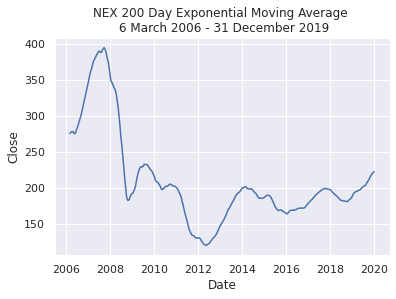

In [6]:
# Calculate 200 day exponential moving average
nex_full['Close_EMA'] = nex_full['Close'].ewm(span=200, adjust=False).mean()

h = sns.lineplot(data=nex_full, x='Date', y='Close_EMA')
h.set_title('NEX 200 Day Exponential Moving Average \n 6 March 2006 - 31 December 2019')
h.set_ylabel('Close')

## Subset of the NEX index

The full NEX index is an equal-weight index with a component weight of $\frac{102 stocks}{100}=$ 0.98039216 as of Q1 2021. We, on the other hand, are using a subset of the NEX index, consisting of just 36 companies out of the current 102. Moreover, not all companies have been listed on the stock markets for the entire duration of our the dataset (some companies go public after others also, not all companies have been publicly traded prior to 2000). This poses the question of how we would weigth our sub-index. Ideally, we would weigth the components of our subset of the NEX in such a way that best reflects the price trends of the full NEX.

In [7]:
nex_subset = pd.read_csv('./Data/NEX_subset_prices.csv', index_col='Date')
nex_subset = nex_subset.fillna(0)
nex_subset = nex_subset.loc['2004-01-01':'2016-12-31']

In [8]:
nex_subset.index = pd.to_datetime(nex_subset.index)

Text(0, 0.5, 'Close')

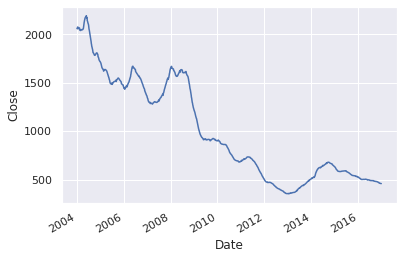

In [9]:
h = nex_subset.sum(axis=1).ewm(span=200, adjust=False).mean().plot()
h.set_ylabel('Close')

### Approach 1: Constant Equal Weights
The first and most simple approach is to again use equal weigthing. 

Let *$C$* be the total number of companies in our sub-index. Then *$w_c = \frac{1}{C}$* is the weight of any given company $c$.

In [10]:
# calculate weights
C = nex_subset.shape[1]
w = 1 / C

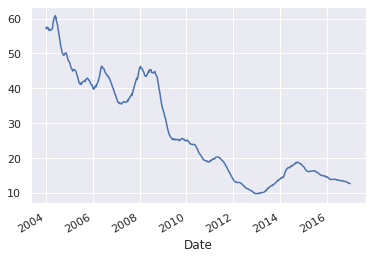

In [11]:
# calculate weighted price data
nex_subset_ceqw = (nex_subset * w).sum(axis=1)
nex_subset_ceqw = nex_subset_ceqw.ewm(span=200, adjust=False).mean()

h = nex_subset_ceqw.plot()
h.xaxis.set_major_formatter(DateFormatter('%Y'))

### Approach 2: Dynamic Weights

Another approach would be to apply a dynamic weighting method with which every trading day gets weighted based on the numer of companies being traded on that day.

Let $C$ be the number of companies and
    $
        b_{c, t} = 
            \begin{cases} 
                0 & \text{company $c$ has } \textbf{not } \text{traded on trading day $t$,}\\ 
                1 & \text{company $c$ has traded on trading day $t$}\\
             \end{cases}
    $ denote whether a company $c$ has traded on a day $t$. Then $w_{t} = \frac{1}{\sum_{c=0}^C b_{c, t}}$ is the weight of a given trading day $t$.

In [12]:
C = nex_subset.shape[1]
W = (1 / (nex_subset > 0).astype(int).sum(axis=1))

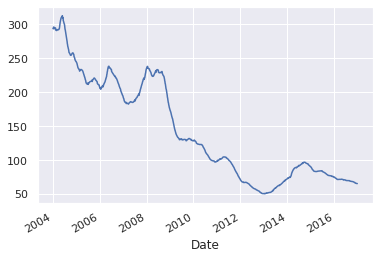

In [13]:
nex_subset_dw = (nex_subset.T * W[0]).T.sum(axis=1)
nex_subset_dw = nex_subset_dw.ewm(span=200, adjust=False).mean()

h = nex_subset_dw.plot()

### Approach 3: Dynamic Equal Weights

A third possible approach is, instead of calculating the trading day weights based on the number of companies traded on the given date, to use the number of companies already listed on the markets.

Let $C_{t'}$ be the number of companies being traded on or before trading day $t$, then $w_{t} = \frac{1}{C_{t'}}$ is the weight of a given trading day $t$.

In [14]:
W = (1 / (nex_subset.cumsum() > 0).astype(int).sum(axis=1))

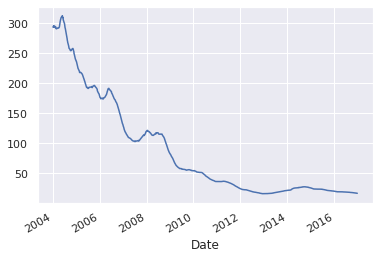

In [15]:
nex_subset_deqw = nex_subset.sum(axis=1) * W
nex_subset_deqw = nex_subset_deqw.ewm(span=200, adjust=False).mean()

h = nex_subset_deqw.plot()

### Approach 4: Relative Dynamic Weights

Relative to the number of companies

In [16]:
C = nex_subset.shape[1]
W = (nex_subset > 0).astype(int).sum(axis=1) / C

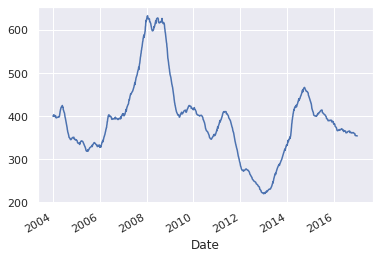

In [17]:
nex_subset_rdw = (nex_subset.T * W).T.sum(axis=1)
nex_subset_rdw = nex_subset_rdw.ewm(span=200, adjust=False).mean()


h = nex_subset_rdw.plot()

## Deciding on a weigthing method

## Correlation analysis

[Text(0, 0.5, 'Full'),
 Text(0, 1.5, 'Subset Constant Equal Weights'),
 Text(0, 2.5, 'Subset Dynamic Weights'),
 Text(0, 3.5, 'Subset Dynamic Equal Weights'),
 Text(0, 4.5, 'Subset Relative Dynamic Weights')]

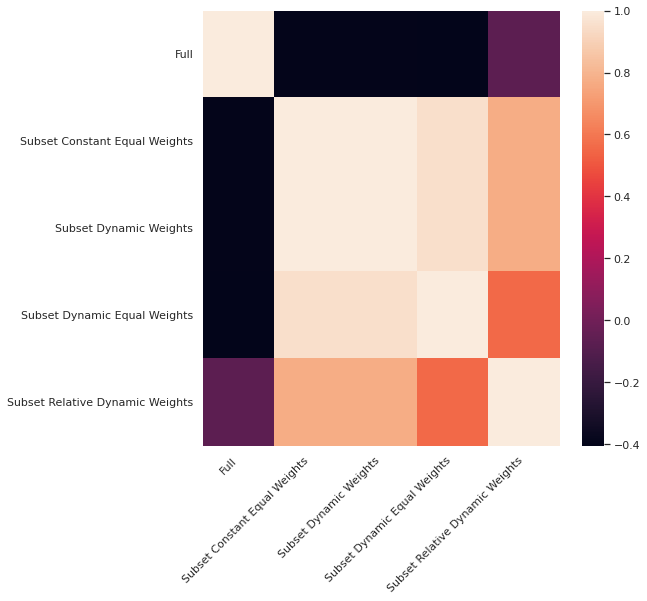

In [18]:
# Find common dates with price data between the full NEX and our subset.
# This is done in order to construct vectors of the same length to be used 
# in our decision analysis.
common_dates = set(nex_full['Date'].astype(str)).intersection(set(nex_subset.index.astype(str)))
common_dates = sorted(list(common_dates))
common_dates = np.array(common_dates)

nex_full = nex_full[nex_full['Date'].isin(pd.to_datetime(common_dates))]

nex_subset_ceqw = nex_subset_ceqw.loc[common_dates]
nex_subset_dw   = nex_subset_dw.loc[common_dates]
nex_subset_deqw = nex_subset_deqw.loc[common_dates]
nex_subset_rdw  = nex_subset_rdw.loc[common_dates]

corr = np.corrcoef(np.array([nex_full['Close_EMA'], nex_subset_ceqw, 
                             nex_subset_dw, nex_subset_deqw, 
                             nex_subset_rdw]))

labels = ['Full', 'Subset Constant Equal Weights', 
          'Subset Dynamic Weights', 'Subset Dynamic Equal Weights',
          'Subset Relative Dynamic Weights']

plt.figure(figsize=(8, 8))
h = sns.heatmap(corr)
h.set_xticklabels(labels=labels, rotation=45, ha='right')
h.set_yticklabels(labels=labels, rotation=0 , va='center')

## Curve distances

In [19]:
import similaritymeasures

def curve_distances(full, subset):
    full = full.reset_index(drop=True)
    subset = subset.reset_index().drop('Date', axis=1)
    
    full = np.array([full.index, full['Close_EMA'].values]).T
    subset = np.array([subset.index, subset.values.flatten()]).T
    
    df = similaritymeasures.frechet_dist(full, subset)
    dtw, d = similaritymeasures.dtw(full, subset)
    pcm = similaritymeasures.pcm(full, subset)
    area = similaritymeasures.area_between_two_curves(full, subset)
    cl = similaritymeasures.curve_length_measure(full, subset)

    return [df, dtw, pcm, cl, area]


# distances = [curve_distances(nex_full, nex_subset_ceqw), curve_distances(nex_full, nex_subset_dw),
#              curve_distances(nex_full, nex_subset_deqw), curve_distances(nex_full, nex_subset_rdw)]

In [20]:
# These are the distances computed in the above cell.
# Not a chance I run this again, this is why they are hardcoded.
"""
   ----------------------------------------------------------------------------------------------------
   |Frechet distance   | Dynamic time     | Partial curve     | Area between      | Curve length      |
   |                   | wrapping         | mapping           | two curves        | measure           |
   ----------------------------------------------------------------------------------------------------
"""
distances = np.array([
    [377.3615982301692 , 660629.3809538449, 1078.1061617823611, 43.696687405798755, 660417.0106038221], # Constant equal weights
    [326.8020914096071 , 425801.1065778805, 1944.1194202349955, 33.98027927641884 , 425832.8064682316], # Dynamic weights
    [373.28870838855727, 566378.8026691248, 2549.386838249199 , 39.00175426131634 , 566399.4895441867], # Dynamic equal weights
    [438.3536857537007 , 737626.4077532532, 1024.0574637893276, 50.14043615019269 , 738999.6963822402]  # Relative dynamic weights
])

distance_measures = ['Frechet distance', 'Dynamic time wrapping', 'Partial curve',
                     'Area between two curves', 'Curve length measure']

weighting_methods = ['Constant equal weights', 'Dynamic weights',
                     'Dynamic equal weights', 'Relative dynamic weights']

for dm, i in zip(distance_measures, np.argmin(distances, axis=0)):
    print(f'{weighting_methods[i]} ({dm})')

Dynamic weights (Frechet distance)
Dynamic weights (Dynamic time wrapping)
Relative dynamic weights (Partial curve)
Dynamic weights (Area between two curves)
Dynamic weights (Curve length measure)


## Euclidean distance of normalized price data

For this we will normalize the sorted price data both for the full NEX and the differently weighted subsets and calculate the euclidean distance.

Let $p_t$ be the price data on a given trading day $t$, $p_{max}$ the maximal price for the whole time frame, then $p_t'=\frac{p_t}{p_{max}} \Rightarrow p_t' \in [0, 1]$ is the normalized price.

In [21]:
def euclidean_distance(full, subset):
    a = nex_full['Close_EMA_norm']
    
    b = subset / subset.max()
    b = b.loc[common_dates]
    b = b.values
    
    
    return np.linalg.norm(a - b)

In [22]:
nex_full['Close_EMA_norm'] = nex_full['Close_EMA'] / nex_full['Close_EMA'].max()

distances = [
    euclidean_distance(nex_full, nex_subset_ceqw),
    euclidean_distance(nex_full, nex_subset_dw),
    euclidean_distance(nex_full, nex_subset_deqw),
    euclidean_distance(nex_full, nex_subset_rdw)
]

i = np.argmin(distances)
print(weighting_methods[i])

Relative dynamic weights
